# My Project: Can we predict the outcome of cricket matches?


### Difficulty 1: Accurately predict the outcome of a cricket match
### Difficulty 2:Determine which variables are most important and logical

## STEP 1:  Full process of deriving the final data frame

### Points to note:

1.  There was one game where team2's half-time data was not found in the innings_data, probably because team2 did not play, which is the same game as one game no result, which was identified by the news that rain interrupted the game on that day, which is a very special case, so I chose to skip this game directly and created a data frame with only records This was a very special case, so I chose to skip the match and create the initial data frame with only 123 matches, or 246 rows of data.


2.  In "The Hundred" cricket there are 20 overs per team and each over has 5 deliveries, so the first half of the game is a count of team1's score and wicket player out only!! And is only relevant for teams whose toss decision is bat!!


3.  Wicket type: Bowled; Caught; Run out; Leg before wicket (LBW); Stumped; Hit wicket; Handled the ball; Obstructing the field; Hit the ball twice; Timed out.



In [26]:
import pandas as pd
print(pd.__version__)

import numpy as np
import json
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

1.4.2


In [2]:
folder_path = os.getcwd() + '/hnd_json/'  
data_frame_list = []

home_venues = {
    "Southern Brave": "The Rose Bowl, Southampton",
    "Birmingham Phoenix": "Edgbaston, Birmingham",
    "Trent Rockets": "Trent Bridge, Nottingham",
    "Oval Invincibles": "Kennington Oval, London",
    "London Spirit": "Lord's, London",
    "Welsh Fire": "Sophia Gardens, Cardiff",
    "Manchester Originals": "Old Trafford, Manchester",
    "Northern Superchargers": "Headingley, Leeds"
}


def calculate_scores_and_wickets_per_match(data_dict):
    total_score = 0
    total_wickets_player_out = 0
    for innings in data_dict["innings"]:
        if innings["team"] == data_dict["info"]["teams"][0]:  # 如果是第一个队伍
            for over in innings["overs"]:
                for delivery in over["deliveries"]:
                    total_score += delivery["runs"]["total"]
                    if "wickets" in delivery:
                        total_wickets_player_out += len(delivery["wickets"])  
            break  # 只统计第一队的比赛数据，统计完后立即退出循环
    return total_score, total_wickets_player_out


for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        with open(os.path.join(folder_path, file_name), 'r') as f:
            data_dict = json.load(f)
            
            info_data = data_dict['info']

            team1 = info_data['teams'][0]
            team2 = info_data['teams'][1]
            
            gender = info_data['gender']
            season = info_data['season']
            
            date = info_data['dates'][0]
            
            match_number = info_data['event'].get('match_number', 'unknown')  
            
            venue = info_data['venue']
            city = info_data['city']
                    
            home_advantage_team1 = 'yes' if home_venues[team1] == venue else 'no'
            home_advantage_team2 = 'yes' if home_venues[team2] == venue else 'no'
            #home_advantage and toss_winner may be strong relationship          
            
            toss_winner = info_data['toss']['winner']
            toss_decision = info_data['toss']['decision']
            
            choose_to_bat_team1, choose_to_field_team1, forced_to_bat_team1, forced_to_field_team1 = 'no', 'no', 'no', 'no'
            choose_to_bat_team2, choose_to_field_team2, forced_to_bat_team2, forced_to_field_team2 = 'no', 'no', 'no', 'no'
 
            if toss_decision == 'bat':
                if toss_winner == team1:
                    choose_to_bat_team1 = 'yes'
                    forced_to_field_team2 = 'yes'
                else:
                    choose_to_bat_team2 = 'yes'
                    forced_to_field_team1 = 'yes'
            else:
                if toss_winner == team1:
                    choose_to_field_team1 = 'yes'
                    forced_to_bat_team2 = 'yes'
                else:
                    choose_to_field_team2 = 'yes'
                    forced_to_bat_team1 = 'yes'
                       
          
            # Set the reverse decision for the losing team based on the toss decision
            toss_decision_loser = 'field' if toss_decision == 'bat' else 'bat'
            toss_decision_team1 = toss_decision if toss_winner == team1 else toss_decision_loser
            toss_decision_team2 = toss_decision if toss_winner == team2 else toss_decision_loser
            
            winner = info_data['outcome'].get('winner', 'no winner')  

            result_team1 = 'win' if winner == team1 else ('loose' if winner == team2 else 'no result')
            result_team2 = 'win' if winner == team2 else ('loose' if winner == team1 else 'no result')
            if result_team1 == 'no result' or result_team2 == 'no result':
                continue
            
            total_score, total_wickets_player_out = calculate_scores_and_wickets_per_match(data_dict)
            

            data_frame_list.append([result_team1, team1, team2, gender, season, date, match_number, venue, city, home_advantage_team1, 
                        toss_winner, toss_decision_team1,
                        choose_to_bat_team1, choose_to_field_team1, forced_to_bat_team1, forced_to_field_team1,  
                        winner,total_score,total_wickets_player_out])


            data_frame_list.append([result_team2, team2, team1, gender, season, date, match_number, venue, city, home_advantage_team2, 
                        toss_winner, toss_decision_team2,
                        choose_to_bat_team2, choose_to_field_team2, forced_to_bat_team2, forced_to_field_team2, 
                        winner,total_score,total_wickets_player_out])

                            
df = pd.DataFrame(data_frame_list, columns=['Result', 'team', 'opponent', 'gender', 'season','date', 
                                            'match_number', 'venue', 'city', 'home_advantage',
                                            'toss_winner', 'toss_decision', 
                                            'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field',
                                            'winner','total_score','total_wickets_player_out'])

In [3]:
# convert 'date' to datetime object
df['date'] = pd.to_datetime(df['date'])

# sort by 'season' and 'date'
df = df.sort_values(by=['season', 'date'])

df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(columns=['date'])

column_order = ['Result','match_number', 'total_score','total_wickets_player_out', 
                'team', 'opponent',
                'gender', 'season', 
                'month','day', 
                'home_advantage','venue', 'city', 
                'toss_winner', 'winner',
                'toss_decision',
                'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field']
                                            

df = df[column_order]
df= df.reset_index(drop=True)

In [4]:
df #the initial data frame

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
0,loose,1,135,6,Manchester Originals,Oval Invincibles,female,2021,7,21,no,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,yes,no,no,no
1,win,1,135,6,Oval Invincibles,Manchester Originals,female,2021,7,21,yes,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,field,no,no,no,yes
2,win,1,145,8,Oval Invincibles,Manchester Originals,male,2021,7,22,yes,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,no,no,yes,no
3,loose,1,145,8,Manchester Originals,Oval Invincibles,male,2021,7,22,no,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,field,no,yes,no,no
4,loose,2,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,yes,"Edgbaston, Birmingham",Birmingham,London Spirit,London Spirit,bat,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,loose,unknown,134,6,Trent Rockets,Southern Brave,female,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,Trent Rockets,Southern Brave,field,no,yes,no,no
242,loose,unknown,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,bat,yes,no,no,no
243,win,unknown,120,9,Trent Rockets,Manchester Originals,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,field,no,no,no,yes
244,loose,unknown,101,7,Southern Brave,Oval Invincibles,female,2022,9,3,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,yes,no,no,no


## About 'match_number'

1.  Those without match numbers are semi-finals and finals, while the maximum match number for women's cricket in 2022 is known to be 22 and the maximum match number for all three types of matches, 2022 men, 2021 men and 2021 women, is 32.

2.  To distinguish significantly between the semi-finals and finals, assign a value of 40 to the semi-finals and 50 to the finals.

In [5]:
matches_without_number = df[df.iloc[:,1]=='unknown'] #8 matches 
matches_without_number

#I found that the 8 matches without a match number all had a common date
#2021-08-20, 2021-08-21
#2022-09-02, 2022-09-03
#The eight races are the knockout and final races for both men and women in each season

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
118,loose,unknown,96,10,Trent Rockets,Southern Brave,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,bat,no,no,yes,no
119,win,unknown,96,10,Southern Brave,Trent Rockets,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,field,no,yes,no,no
120,win,unknown,114,7,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,yes,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,bat,no,no,yes,no
121,loose,unknown,114,7,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,no,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,field,no,yes,no,no
122,win,unknown,168,5,Southern Brave,Birmingham Phoenix,male,2021,8,21,no,"Lord's, London",London,Birmingham Phoenix,Southern Brave,bat,no,no,yes,no
123,loose,unknown,168,5,Birmingham Phoenix,Southern Brave,male,2021,8,21,no,"Lord's, London",London,Birmingham Phoenix,Southern Brave,field,no,yes,no,no
124,win,unknown,121,6,Oval Invincibles,Southern Brave,female,2021,8,21,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,no,no,yes,no
125,loose,unknown,121,6,Southern Brave,Oval Invincibles,female,2021,8,21,no,"Lord's, London",London,Southern Brave,Oval Invincibles,field,no,yes,no,no
238,loose,unknown,150,7,London Spirit,Manchester Originals,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,bat,yes,no,no,no
239,win,unknown,150,7,Manchester Originals,London Spirit,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,field,no,no,no,yes


In [6]:
# Exclude rows where match_number is 'unknown'
matches_with_number = df[df['match_number'] != 'unknown']

# Convert the match_number column to integers
matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)

# Check the minimum, maximum and the distribution of match numbers
min_match_number = matches_with_number['match_number'].min()
max_match_number = matches_with_number['match_number'].max()
distribution = matches_with_number['match_number'].value_counts().sort_index()

print(f'Minimum match number: {min_match_number}')
print(f'Maximum match number: {max_match_number}')
print('Distribution of match numbers:')
print(distribution)

Minimum match number: 1
Maximum match number: 32
Distribution of match numbers:
1     8
2     8
3     8
4     8
5     6
6     8
7     8
8     8
9     4
10    8
11    8
12    8
13    8
14    8
15    8
16    8
17    8
18    8
19    6
20    8
21    8
22    6
23    8
24    8
25    6
26    6
27    6
28    6
29    6
30    6
31    6
32    6
Name: match_number, dtype: int64


/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_87004/3728442574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)


## Points to note:

1.  Obviously 2021 08 20 is the semi-final, 2021 08 21 is the final, 2022 09 02 is the semi-final and 2022 09 03 is the final. You can also tell from the information on the afterwards that because the men's and women's match numbers for 2021 are up to 32, while the women's match number for 2022 is only up to 24. So I think we should set the match number to 40 for all the semi-finals and 50 for the finals.


     
2.  The women's competition was curtailed due to the inclusion of women's cricket at the 2022 Commonwealth Games in Birmingham, reducing the number of players who were available for the start of the contest. As a result, the women's contest started a week later and each women's team only played six matches in the group stage, meaning some sides did not meet each other at that point in the competition.



2021 men's team match_number is missing 5, 9 and 19;


2021 women's team match_number is missing 9 and 22;
   
   
2022 men's team match_number from 1-32 not missing;
   
   
2022 women's team match_number is missing 25-32.

In [7]:
# make sure season, month and day are integers
df['season'] = df['season'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

# define a function to assign match numbers
def assign_match_number(row):
    if row['season'] == 2021 and row['month'] == 8 and row['day'] == 20:
        return 40  # semi-finals
    elif row['season'] == 2021 and row['month'] == 8 and row['day'] == 21:
        return 50  # finals
    elif row['season'] == 2022 and row['month'] == 9 and row['day'] == 2:
        return 40  # semi-finals
    elif row['season'] == 2022 and row['month'] == 9 and row['day'] == 3:
        return 50  # finals
    else:
        return row['match_number']  # keep the original match number

# apply the function to the 'match_number' column
df['match_number'] = df.apply(assign_match_number, axis=1)

In [8]:
df[df['match_number']==40] # semi-finals in two seasons

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
118,loose,40,96,10,Trent Rockets,Southern Brave,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,bat,no,no,yes,no
119,win,40,96,10,Southern Brave,Trent Rockets,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,field,no,yes,no,no
120,win,40,114,7,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,yes,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,bat,no,no,yes,no
121,loose,40,114,7,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,no,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,field,no,yes,no,no
238,loose,40,150,7,London Spirit,Manchester Originals,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,bat,yes,no,no,no
239,win,40,150,7,Manchester Originals,London Spirit,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,field,no,no,no,yes
240,win,40,134,6,Southern Brave,Trent Rockets,female,2022,9,2,yes,"The Rose Bowl, Southampton",Southampton,Trent Rockets,Southern Brave,bat,no,no,yes,no
241,loose,40,134,6,Trent Rockets,Southern Brave,female,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,Trent Rockets,Southern Brave,field,no,yes,no,no


In [9]:
df[df['match_number']==50] #finals in two seasons

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
122,win,50,168,5,Southern Brave,Birmingham Phoenix,male,2021,8,21,no,"Lord's, London",London,Birmingham Phoenix,Southern Brave,bat,no,no,yes,no
123,loose,50,168,5,Birmingham Phoenix,Southern Brave,male,2021,8,21,no,"Lord's, London",London,Birmingham Phoenix,Southern Brave,field,no,yes,no,no
124,win,50,121,6,Oval Invincibles,Southern Brave,female,2021,8,21,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,no,no,yes,no
125,loose,50,121,6,Southern Brave,Oval Invincibles,female,2021,8,21,no,"Lord's, London",London,Southern Brave,Oval Invincibles,field,no,yes,no,no
242,loose,50,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,bat,yes,no,no,no
243,win,50,120,9,Trent Rockets,Manchester Originals,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,field,no,no,no,yes
244,loose,50,101,7,Southern Brave,Oval Invincibles,female,2022,9,3,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,yes,no,no,no
245,win,50,101,7,Oval Invincibles,Southern Brave,female,2022,9,3,no,"Lord's, London",London,Southern Brave,Oval Invincibles,field,no,no,no,yes


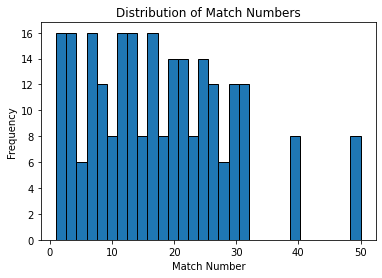

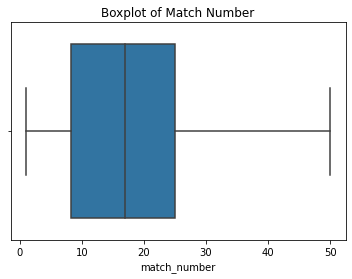

In [10]:
df_copy = df.copy()
df_copy['match_number'] = pd.to_numeric(df_copy['match_number'], errors='coerce')

match_numbers = df_copy['match_number'].dropna()

plt.figure(figsize=(6, 4))
plt.hist(match_numbers, bins=30, edgecolor='black')
plt.title('Distribution of Match Numbers')
plt.xlabel('Match Number')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x=match_numbers)
plt.title('Boxplot of Match Number')
plt.show()

In [11]:
df['match_number'].replace('unknown', np.nan, inplace=True)
df['match_number'] = df['match_number'].astype(float)

def check_match_number_distribution(df, season, gender):
    # Filter dataframe by gender and season and reset index
    df_gender_season = df[(df['gender'] == gender) & (df['season'] == int(season))].reset_index(drop=True)
    
    # Exclude rows where match_number is 'Unknown' or non-numeric
    matches_with_number = df_gender_season[pd.to_numeric(df_gender_season['match_number'], errors='coerce').notna()]
    
    # Convert the match_number column to integers
    matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)
    
    # Check the minimum, maximum and the distribution of match numbers
    min_match_number = matches_with_number['match_number'].min()
    max_match_number = matches_with_number['match_number'].max()
    distribution = matches_with_number['match_number'].value_counts().sort_index()

    print(f'In {season} season for {gender}:')
    print(f'Minimum match number: {min_match_number}')
    print(f'Maximum match number: {max_match_number}')
    print('Distribution of match numbers:')
    print(distribution)
    print('--------------------')

# Check the match number distribution for 2021 and 2022 for both genders
check_match_number_distribution(df, '2021', 'male')
check_match_number_distribution(df, '2021', 'female')
check_match_number_distribution(df, '2022', 'male')
check_match_number_distribution(df, '2022', 'female')

In 2021 season for male:
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
6     2
7     2
8     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
20    2
21    2
22    2
23    2
24    2
25    2
26    2
27    2
28    2
29    2
30    2
31    2
32    2
40    2
50    2
Name: match_number, dtype: int64
--------------------
In 2021 season for female:
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    2
20    2
21    2
23    2
24    2
25    2
26    2
27    2
28    2
29    2
30    2
31    2
32    2
40    2
50    2
Name: match_number, dtype: int64
--------------------
In 2022 season for male:
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2

### Having already assigned the missing values in match_number, the whole df_bat can be divided into four subsets according to season and male and female, looking at them from smallest to largest match number

In [12]:
df_2021 = df.loc[df['season'] == 2021] 

df_2022 = df.loc[df['season'] == 2022] 

df_2021_men = df_2021.loc[df_2021['gender'] == 'male'] 
df_2021_women = df_2021.loc[df_2021['gender'] == 'female'] 

df_2022_men = df_2022.loc[df_2022['gender'] == 'male'] 
df_2022_women = df_2022.loc[df_2022['gender'] == 'female']

df_2021_men = df_2021_men.sort_values('match_number')
df_2021_women = df_2021_women.sort_values('match_number')

df_2022_men = df_2022_men.sort_values('match_number')
df_2022_women = df_2022_women.sort_values('match_number')

In [13]:
df_2021_men #31 matches, with the deletion of the one with no result
#19th Match (N), Manchester, August 05, 2021

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
2,win,1.0,145,8,Oval Invincibles,Manchester Originals,male,2021,7,22,yes,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,no,no,yes,no
3,loose,1.0,145,8,Manchester Originals,Oval Invincibles,male,2021,7,22,no,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,field,no,yes,no,no
6,loose,2.0,144,6,London Spirit,Birmingham Phoenix,male,2021,7,23,no,"Edgbaston, Birmingham",Birmingham,Birmingham Phoenix,Birmingham Phoenix,bat,no,no,yes,no
7,win,2.0,144,6,Birmingham Phoenix,London Spirit,male,2021,7,23,yes,"Edgbaston, Birmingham",Birmingham,Birmingham Phoenix,Birmingham Phoenix,field,no,yes,no,no
8,loose,3.0,126,8,Southern Brave,Trent Rockets,male,2021,7,24,no,"Trent Bridge, Nottingham",Nottingham,Southern Brave,Trent Rockets,bat,yes,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,win,32.0,163,5,Welsh Fire,London Spirit,male,2021,8,18,yes,"Sophia Gardens, Cardiff",Cardiff,Welsh Fire,Welsh Fire,field,no,yes,no,no
118,loose,40.0,96,10,Trent Rockets,Southern Brave,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,bat,no,no,yes,no
119,win,40.0,96,10,Southern Brave,Trent Rockets,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,field,no,yes,no,no
122,win,50.0,168,5,Southern Brave,Birmingham Phoenix,male,2021,8,21,no,"Lord's, London",London,Birmingham Phoenix,Southern Brave,bat,no,no,yes,no


In [14]:
df_2021_women #32 matches

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
0,loose,1.0,135,6,Manchester Originals,Oval Invincibles,female,2021,7,21,no,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,yes,no,no,no
1,win,1.0,135,6,Oval Invincibles,Manchester Originals,female,2021,7,21,yes,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,field,no,no,no,yes
4,loose,2.0,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,yes,"Edgbaston, Birmingham",Birmingham,London Spirit,London Spirit,bat,no,no,yes,no
5,win,2.0,128,6,London Spirit,Birmingham Phoenix,female,2021,7,23,no,"Edgbaston, Birmingham",Birmingham,London Spirit,London Spirit,field,no,yes,no,no
14,win,3.0,133,5,Southern Brave,Trent Rockets,female,2021,7,24,no,"Trent Bridge, Nottingham",Nottingham,Trent Rockets,Southern Brave,bat,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,win,32.0,95,9,London Spirit,Welsh Fire,female,2021,8,18,no,"Sophia Gardens, Cardiff",Cardiff,London Spirit,London Spirit,field,no,yes,no,no
120,win,40.0,114,7,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,yes,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,bat,no,no,yes,no
121,loose,40.0,114,7,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,no,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,field,no,yes,no,no
124,win,50.0,121,6,Oval Invincibles,Southern Brave,female,2021,8,21,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,no,no,yes,no


In [15]:
df_2022_men #32 matches +2 matches (Semi-final and final)

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
126,loose,1.0,107,7,Welsh Fire,Southern Brave,male,2022,8,3,no,"The Rose Bowl, Southampton",Southampton,Southern Brave,Southern Brave,bat,no,no,yes,no
127,win,1.0,107,7,Southern Brave,Welsh Fire,male,2022,8,3,yes,"The Rose Bowl, Southampton",Southampton,Southern Brave,Southern Brave,field,no,yes,no,no
128,win,2.0,171,6,London Spirit,Oval Invincibles,male,2022,8,4,no,"Kennington Oval, London",London,Oval Invincibles,London Spirit,bat,no,no,yes,no
129,loose,2.0,171,6,Oval Invincibles,London Spirit,male,2022,8,4,yes,"Kennington Oval, London",London,Oval Invincibles,London Spirit,field,no,yes,no,no
130,loose,3.0,161,4,Manchester Originals,Northern Superchargers,male,2022,8,5,yes,"Old Trafford, Manchester",Manchester,Northern Superchargers,Northern Superchargers,bat,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,win,32.0,143,9,Manchester Originals,Oval Invincibles,male,2022,8,31,yes,"Old Trafford, Manchester",Manchester,Oval Invincibles,Manchester Originals,field,no,no,no,yes
238,loose,40.0,150,7,London Spirit,Manchester Originals,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,bat,yes,no,no,no
239,win,40.0,150,7,Manchester Originals,London Spirit,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,field,no,no,no,yes
242,loose,50.0,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,bat,yes,no,no,no


In [16]:
df_2022_women #24 matches +2 matches (Semi-final and final)

#The following sides did not play each other in the group stage, 
#due to the shortened women's competition: 
#Oval Invincibles and Welsh Fire, 
#Northern Superchargers and Trent Rockets, 
#London Spirit and Manchester Originals, 
#Southern Brave and Birmingham Phoenix.

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
142,loose,1.0,143,5,Northern Superchargers,Oval Invincibles,female,2022,8,11,no,"Kennington Oval, London",London,Oval Invincibles,Oval Invincibles,bat,no,no,yes,no
143,win,1.0,143,5,Oval Invincibles,Northern Superchargers,female,2022,8,11,yes,"Kennington Oval, London",London,Oval Invincibles,Oval Invincibles,field,no,yes,no,no
146,loose,2.0,155,4,London Spirit,Southern Brave,female,2022,8,12,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Southern Brave,bat,yes,no,no,no
147,win,2.0,155,4,Southern Brave,London Spirit,female,2022,8,12,yes,"The Rose Bowl, Southampton",Southampton,London Spirit,Southern Brave,field,no,no,no,yes
152,win,3.0,119,5,Trent Rockets,Manchester Originals,female,2022,8,13,no,"Old Trafford, Manchester",Manchester,Manchester Originals,Trent Rockets,bat,no,no,yes,no
153,loose,3.0,119,5,Manchester Originals,Trent Rockets,female,2022,8,13,yes,"Old Trafford, Manchester",Manchester,Manchester Originals,Trent Rockets,field,no,yes,no,no
154,win,4.0,161,5,Birmingham Phoenix,Welsh Fire,female,2022,8,13,no,"Sophia Gardens, Cardiff",Cardiff,Welsh Fire,Birmingham Phoenix,bat,no,no,yes,no
155,loose,4.0,161,5,Welsh Fire,Birmingham Phoenix,female,2022,8,13,yes,"Sophia Gardens, Cardiff",Cardiff,Welsh Fire,Birmingham Phoenix,field,no,yes,no,no
164,win,5.0,127,4,Northern Superchargers,London Spirit,female,2022,8,14,yes,"Headingley, Leeds",Leeds,London Spirit,Northern Superchargers,bat,no,no,yes,no
165,loose,5.0,127,4,London Spirit,Northern Superchargers,female,2022,8,14,no,"Headingley, Leeds",Leeds,London Spirit,Northern Superchargers,field,no,yes,no,no


### Points to note: About 2 seasons of men's and women's matches

According to the official information:

1.    Both men's and women's cricket 2021 will have 32 matches each in the group stage, plus their respective semi-finals and finals, which should give a total of 64+4=68 matches.
2.    However, due to incomplete data, the 2021 men's matches with match_numbers = 5,9,19('no result',deleted) and the 2021 women's matches with match_number = 9,22 are missing, making a total of 4 matches missing and 1 deleted, so the figure for 2021 is only 64 matches.
3.    For the 2022 men's group matches there are 32 matches, plus the semi-finals and finals, making a total of 34 matches;
4.    For the 2022 women's group matches there are 24 matches, plus the semi-finals and finals, making a total of 26 matches.




| Season | 2021 | 2022 | Total matches |
|---------|---------|---------|---------|
|   MEN |   29+2=31 |   32+2=34 | 65    |
|   WOMEN |   30+2=32 |   24+2=26 | 58    |
|   Total matches  |   63 |   60 |   123  |


## About the team's historical performance

Four new columns of variables have been added to evaluate a team's historical performance: 

1.average win percentage, 

2.average half-court score, 

3.average number of outs, 

4.the team's last match results

Note that even though the team names are the same, I have differentiated the statistics between the men's and women's teams.

Sometimes teams appear in the 'opponent' rather than the 'team' column, so we need to consider historical performance in a large 'df' context rather than just in 'df_bat'.

In [17]:
df

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
0,loose,1.0,135,6,Manchester Originals,Oval Invincibles,female,2021,7,21,no,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,yes,no,no,no
1,win,1.0,135,6,Oval Invincibles,Manchester Originals,female,2021,7,21,yes,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,field,no,no,no,yes
2,win,1.0,145,8,Oval Invincibles,Manchester Originals,male,2021,7,22,yes,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,no,no,yes,no
3,loose,1.0,145,8,Manchester Originals,Oval Invincibles,male,2021,7,22,no,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,field,no,yes,no,no
4,loose,2.0,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,yes,"Edgbaston, Birmingham",Birmingham,London Spirit,London Spirit,bat,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,loose,40.0,134,6,Trent Rockets,Southern Brave,female,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,Trent Rockets,Southern Brave,field,no,yes,no,no
242,loose,50.0,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,bat,yes,no,no,no
243,win,50.0,120,9,Trent Rockets,Manchester Originals,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,field,no,no,no,yes
244,loose,50.0,101,7,Southern Brave,Oval Invincibles,female,2022,9,3,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,yes,no,no,no


In [18]:
df.to_csv('/Users/quinne/Desktop/full_dataframe.csv', index=False)
#save the big df data frame

In [19]:
df_bat= df[df['toss_decision'] == 'bat']
df_bat['original_index'] = df_bat.index

/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_87004/2867824870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bat['original_index'] = df_bat.index


In [20]:
df_bat

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,...,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,original_index
0,loose,1.0,135,6,Manchester Originals,Oval Invincibles,female,2021,7,21,...,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,yes,no,no,no,0
2,win,1.0,145,8,Oval Invincibles,Manchester Originals,male,2021,7,22,...,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,no,no,yes,no,2
4,loose,2.0,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,...,"Edgbaston, Birmingham",Birmingham,London Spirit,London Spirit,bat,no,no,yes,no,4
6,loose,2.0,144,6,London Spirit,Birmingham Phoenix,male,2021,7,23,...,"Edgbaston, Birmingham",Birmingham,Birmingham Phoenix,Birmingham Phoenix,bat,no,no,yes,no,6
8,loose,3.0,126,8,Southern Brave,Trent Rockets,male,2021,7,24,...,"Trent Bridge, Nottingham",Nottingham,Southern Brave,Trent Rockets,bat,yes,no,no,no,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,win,31.0,135,8,Northern Superchargers,Southern Brave,male,2022,8,31,...,"Headingley, Leeds",Leeds,Southern Brave,Northern Superchargers,bat,no,no,yes,no,236
238,loose,40.0,150,7,London Spirit,Manchester Originals,male,2022,9,2,...,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,bat,yes,no,no,no,238
240,win,40.0,134,6,Southern Brave,Trent Rockets,female,2022,9,2,...,"The Rose Bowl, Southampton",Southampton,Trent Rockets,Southern Brave,bat,no,no,yes,no,240
242,loose,50.0,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,...,"Lord's, London",London,Manchester Originals,Trent Rockets,bat,yes,no,no,no,242


In [21]:
#Reorder by team name, gender, season and match number
df = df.sort_values(['team', 'gender','season', 'match_number'])

df['Result_num'] = df['Result'].map({'win': 1, 'loose': 0})

df['avg_win_rate'] = df.groupby(['team', 'gender'])['Result_num'].apply(lambda x: x.shift().expanding().mean())
df['avg_score'] = df.groupby(['team', 'gender'])['total_score'].apply(lambda x: x.shift().expanding().mean())
df['avg_wickets_out'] = df.groupby(['team', 'gender'])['total_wickets_player_out'].apply(lambda x: x.shift().expanding().mean())

df['last_match_result'] = df.groupby(['team', 'gender'])['Result'].shift()

In [22]:
df

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,Result_num,avg_win_rate,avg_score,avg_wickets_out,last_match_result
4,loose,2.0,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,...,bat,no,no,yes,no,0,NaN,NaN,NaN,NaN
18,win,6.0,113,9,Birmingham Phoenix,Manchester Originals,female,2021,7,25,...,bat,yes,no,no,no,1,0.000000,128.000000,6.000000,loose
34,loose,11.0,140,4,Birmingham Phoenix,Southern Brave,female,2021,7,30,...,bat,no,no,yes,no,0,0.500000,120.500000,7.500000,win
53,loose,14.0,145,5,Birmingham Phoenix,Trent Rockets,female,2021,8,1,...,field,no,no,no,yes,0,0.333333,127.000000,6.333333,loose
62,loose,18.0,129,9,Birmingham Phoenix,Oval Invincibles,female,2021,8,4,...,bat,yes,no,no,no,0,0.250000,131.500000,6.000000,loose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,loose,16.0,149,9,Welsh Fire,Manchester Originals,male,2022,8,16,...,field,no,yes,no,no,0,0.272727,148.545455,5.727273,loose
194,loose,22.0,129,8,Welsh Fire,Southern Brave,male,2022,8,22,...,bat,no,no,yes,no,0,0.250000,148.583333,6.000000,loose
205,loose,24.0,156,6,Welsh Fire,London Spirit,male,2022,8,24,...,field,no,yes,no,no,0,0.230769,147.076923,6.153846,loose
212,loose,26.0,114,4,Welsh Fire,Northern Superchargers,male,2022,8,26,...,bat,yes,no,no,no,0,0.214286,147.714286,6.142857,loose


## About 'total_score' is actually halftime score/ runs


In "The Hundred" cricket there are 20 overs per team and 5 deliveries per over, so only Team1's score and wicket player out are counted for the first half of the game!!! These two variables are only valid for teams with a toss decision of bat, as team1 always acts first (either bat or field).

According to traditional cricket rules, if one team chooses to bat first, then they will bat in the first half of the game and keep the field in the second half, the other team is (forced to field). 

Conversely, if one team chooses to field first, then they will field in the first half of the game and bat in the second half, while the other team is forced to bat. 

Therefore, the team batting in the first half is: toss decision for the team batting.

In [23]:
df_bat_new = df[df['toss_decision'] == 'bat']

# and sort it according to the original index
df_bat_new = df_bat_new.sort_values(['season', 'month', 'day', 'match_number'])

In [24]:
df_bat_new #the final data frame

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,Result_num,avg_win_rate,avg_score,avg_wickets_out,last_match_result
0,loose,1.0,135,6,Manchester Originals,Oval Invincibles,female,2021,7,21,...,bat,yes,no,no,no,0,NaN,NaN,NaN,NaN
2,win,1.0,145,8,Oval Invincibles,Manchester Originals,male,2021,7,22,...,bat,no,no,yes,no,1,NaN,NaN,NaN,NaN
4,loose,2.0,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,...,bat,no,no,yes,no,0,NaN,NaN,NaN,NaN
6,loose,2.0,144,6,London Spirit,Birmingham Phoenix,male,2021,7,23,...,bat,no,no,yes,no,0,NaN,NaN,NaN,NaN
14,win,3.0,133,5,Southern Brave,Trent Rockets,female,2021,7,24,...,bat,no,no,yes,no,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,loose,32.0,143,9,Oval Invincibles,Manchester Originals,male,2022,8,31,...,bat,yes,no,no,no,0,0.571429,147.285714,6.071429,win
238,loose,40.0,150,7,London Spirit,Manchester Originals,male,2022,9,2,...,bat,yes,no,no,no,0,0.400000,145.200000,5.933333,loose
240,win,40.0,134,6,Southern Brave,Trent Rockets,female,2022,9,2,...,bat,no,no,yes,no,1,0.800000,125.066667,5.800000,loose
242,loose,50.0,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,...,bat,yes,no,no,no,0,0.533333,157.400000,6.333333,win


In [25]:
#save the final data frame
df_bat_new.reset_index(drop=True).to_csv('/Users/quinne/Desktop/final_dataframe.csv', index=False)